In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.feature_extraction.image import grid_to_graph
from sklearn.cluster import AgglomerativeClustering

In [2]:
def KMeans(data, n_clusters = 20, iterations = 30):
  means = np.random.choice(data.shape[0], n_clusters, replace=False)
  means = data[means]

  assignments = np.zeros(data.shape[0])
  for i in range(iterations):
    distance_matrix = np.sqrt( np.sum( (data[:, np.newaxis] - means[np.newaxis, :]) ** 2, axis=-1 ) )
    assignments = np.argmin(distance_matrix, axis=1)

    for k in range(n_clusters):
      points = np.where(assignments == k)[0]
      cluster_data = data[points]
      if len(cluster_data) > 0:
        means[k] = np.mean(cluster_data, axis=0)

  return assignments, means

In [3]:
def hierarchial_clustering(data, n_clusters = 20):
   assignments = np.array([i for i in range(data.shape[0])])
   means = np.array([data[i] for i in range(data.shape[0])])
   if data.shape[0] < n_clusters:
    return assignments, means

   while np.unique(assignments).shape[0] > n_clusters:

      means = np.array([data[assignments == c].mean(axis = 0) for c in np.unique(assignments)])
      distance_matrix = np.sqrt(np.sum((means[:, np.newaxis] - means[np.newaxis, :]) ** 2, axis=-1 ))
      np.fill_diagonal(distance_matrix, np.inf)

      i, j = np.unravel_index(np.argmin(distance_matrix), distance_matrix.shape)

      clusters = np.unique(assignments)
      c1, c2 = clusters[i], clusters[j]
      assignments[assignments == c2] = c1


      _, assignments = np.unique(assignments, return_inverse=True)

   return assignments, means


In [16]:
def compress_image(image, n_clusters, iterations, method = 'KMeans'):
  image_flatten = image.reshape(image.shape[0] * image.shape[1], image.shape[2]).astype(np.float32)
  if method == 'KMeans':
    assignments, means = KMeans(image_flatten, n_clusters, iterations)
  else:
    assignments, means = hierarchial_clustering(image_flatten, n_clusters)
  compressed_image = means[assignments.astype(int)].reshape(image.shape[0], image.shape[1], image.shape[2])
  compressed_image = np.clip(compressed_image, 0, 255).astype(np.uint8)
  return compressed_image

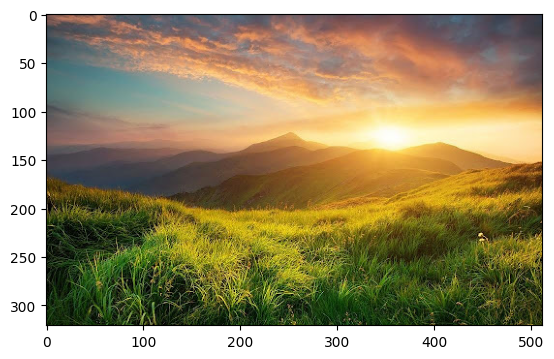

In [17]:
image = cv2.imread('/content/drive/MyDrive/Sem 8/Data mining/image.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

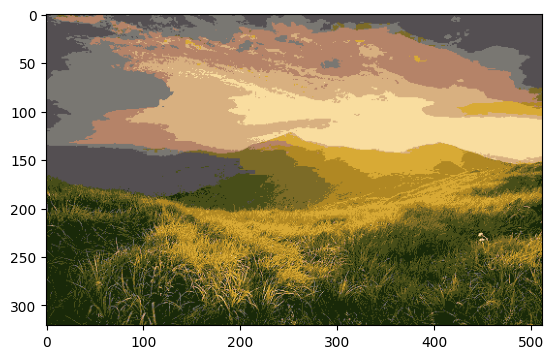

In [23]:
compressed_image = compress_image(image, 10, 10)
plt.imshow(compressed_image)

In [27]:
compressed_image = compress_image(image, 10, 30, 'hierarchial')
plt.imshow(compressed_image)
#Keeps crashing due to large distance matric requiring larger memory

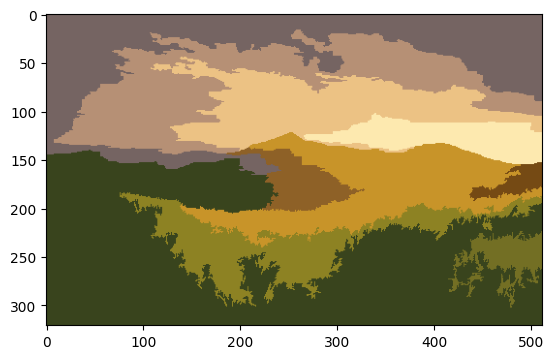

In [31]:
X = image.reshape(-1, 3).astype(np.float32)
n_clusters = 10

connectivity = grid_to_graph(n_x = image.shape[0], n_y = image.shape[1], n_z = 1, mask = None)
model = AgglomerativeClustering(n_clusters = n_clusters, linkage='ward', connectivity = connectivity)

labels = model.fit_predict(X)
compressed = np.zeros_like(X)

for k in range(n_clusters):
    compressed[labels == k] = X[labels == k].mean(axis=0)

compressed_image = compressed.reshape(image.shape[0], image.shape[1], image.shape[2]).astype(np.uint8)
plt.imshow(compressed_image)